# 0.0 Imports

In [58]:
import pandas as pd
import numpy as np
import gzip
import json
import torch

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AutoModelForSequenceClassification
sns.set_style('darkgrid')

# 1.Load Data

In [68]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path, max_rows=200):
  i = 0
  df = {}
  for d in parse(path):
    if i >= max_rows:
        break
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_raw = getDF('/home/edilson07/projects/sentiment_analysis/Electronics_5.json.gz')

In [69]:
df_raw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [70]:
# Tranin Test Split
df_raw, X_test = train_test_split(df_raw, test_size=0.2, random_state=42, stratify=df_raw['overall'])

## 0.2 Drop Unecessary Columns

In [71]:
cols_to_select = ['overall','reviewText']

In [72]:
df_raw = df_raw[cols_to_select]

In [73]:
df_raw.head()

,overall,reviewText
89,5.0,Excellent cover. Very fancy and looks great on...
159,5.0,My Nook charger was not doing so well and cant...
41,5.0,"An excellent product/price, and super-fast shi..."
177,5.0,Works just like it says. Great for streaming m...
66,5.0,"Roland Smith's account, one of life for a teen..."


# 1.0 Transform Data

In [74]:
df = df_raw.copy()

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='overall', ylabel='count'>

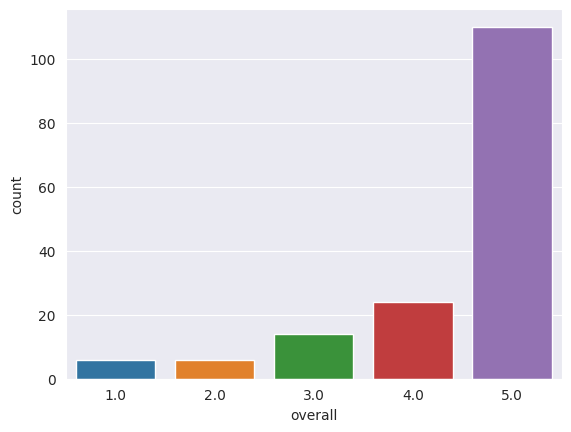

In [75]:
sns.countplot(df, x='overall')

In [76]:
sentiment_dict = {
    5.0 : 'Very Positive',
    4.0 : 'Positive',
    3.0 : 'Neutral',
    2.0 : 'Negative',
    1.0 : 'Negative'
}

In [77]:
df['overall'] = df['overall'].map(sentiment_dict)

## 1.2 NaNs

In [78]:
df.isna().sum()
df = df.dropna()

# 2.0 Train-val split

In [79]:
train, validation = train_test_split(df, test_size=0.2, random_state=42, stratify=df['overall'])

# 3.0 Load Model

In [80]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [81]:
# 1. Mapear sentimentos para IDs numéricos
sentiment_id_map = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Very Positive': 3
}

train['sentiment_id'] = train['overall'].map(sentiment_id_map)
validation['sentiment_id'] = validation['overall'].map(sentiment_id_map)

In [82]:
# Tokenizando os datasets de treinamento e validação
train_encodings = tokenizer(train['reviewText'].tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(validation['reviewText'].tolist(), truncation=True, padding=True, max_length=512)

# 4.0 Prepare Data

In [83]:


train['sentiment_id'] = train['overall'].map(sentiment_id_map)
validation['sentiment_id'] = validation['overall'].map(sentiment_id_map)


class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train['sentiment_id'].values)
val_dataset = SentimentDataset(val_encodings, validation['sentiment_id'].values)

# 5.0 Training

In [84]:
from datasets import load_metric

metric = load_metric("f1")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')

In [85]:
repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [86]:
trainer.train()

/home/edilson07/.pyenv/versions/3.10.11/envs/sentiment_analysis/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.922402,0.203704
2,No log,0.901235,0.203704
3,No log,0.890179,0.203704


TrainOutput(global_step=48, training_loss=0.8981107076009115, metrics={'train_runtime': 511.628, 'train_samples_per_second': 0.751, 'train_steps_per_second': 0.094, 'total_flos': 50869295382528.0, 'train_loss': 0.8981107076009115, 'epoch': 3.0})

In [87]:
trainer.evaluate()

{'eval_loss': 0.9224015474319458,
 'eval_f1': 0.2037037037037037,
 'eval_runtime': 11.4573,
 'eval_samples_per_second': 2.793,
 'eval_steps_per_second': 0.349,
 'epoch': 3.0}

# Analyze predictions

In [ ]:
# Obter previsões no conjunto de validação
predictions, label_ids, _ = trainer.predict(val_dataset)

# Converta as logits das previsões em rótulos previstos
predicted_labels = np.argmax(predictions, axis=1)

# Crie um mapeamento inverso para converter IDs de sentimento de volta para rótulos
id_sentiment_map = {v: k for k, v in sentiment_id_map.items()}

# Visualizar algumas previsões
num_samples = 10  # número de amostras que você deseja visualizar
for i in range(num_samples):
    print(f"Review: {validation['reviewText'].iloc[i]}")
    print(f"Real Sentiment: {id_sentiment_map[label_ids[i]]}")
    print(f"Predicted Sentiment: {id_sentiment_map[predicted_labels[i]]}")
    print("-" * 50)


In [ ]:
# Encontre os índices onde o modelo previu "Negativo"
negative_predicted_indices = np.where(predicted_labels == sentiment_id_map['Very Positive'])[0]

# Visualizar algumas previsões de "Negativo"
num_samples = 10  # número de amostras que você deseja visualizar
for i in negative_predicted_indices[:num_samples]:
    print(f"Review: {validation['reviewText'].iloc[i]}")
    print(f"Real Sentiment: {id_sentiment_map[label_ids[i]]}")
    print(f"Predicted Sentiment: {id_sentiment_map[predicted_labels[i]]}")
    print("-" * 50)